## HeadQuarter

Main notebook that includes data processing and bayesian optimization function

In [3]:
from functions_learning import *
from functions import *
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# to show all columns of a dataframe
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to 25 nl droplet of ECHO machine
# each metabolite min, max and stock must have same units

# concentrations_limits (min, max, stock)
# final format

concentrations_limits = {
 'NTP':(0.78, 3.12, 156), # mM p=156
 'HEPES':(50, 50, 2000), # mM p=2000
 'K_Glutamate':(30, 150, 3000.0), # mM p=2666.66 ***
 'Mg_Glutamate':(0.0, 10, 500), # mM p=500
 'spermidine':(0.1, 1.0, 20), # mM p=20 
 'DTT':(0.0, 3.0, 100), # mM p=100 ***
 'amino_acids':(0.15, 1.5, 6), # mM p=6
 'folinic_acid':(0.0136, 0.068, 2.72), # mM p=2.72
 'tRNA_mix':(0.04, 0.2, 8), # mg/ml p=8
 'PEG':(0.0, 4.0, 50), # % p=50 ***
 'CoA':(0.065, 0.325, 13), # mM p=13
 'NAD':(0.0875, 0.4375, 17.5), # mM p=17.5
 'cAMP':(0.1625, 0.8125, 32.5), # mM p=32.5
 '3-PGA':(4.0, 30, 800), # mM p=800 ***
 'DNA':(20, 20, 1000)} # nM p=1000

In [4]:
# add controls and ref
## Run it for all days


ref_excel = {'NTP':[0.78], 'HEPES':[50.0], 'K_Glutamate':[45.0], 'Mg_Glutamate':[2.5], 'spermidine':[0.3], 'DTT':[0.5],
       'amino_acids':[0.75], 'folinic_acid':[0.0408], 'tRNA_mix':[0.04], 'PEG':[2.0], 'CoA':[0.065], 'NAD':[0.0875],
       'cAMP':[0.325], '3-PGA':[16.0], 'DNA':[20.0]}

jove_protocol = {'NTP':[1.56], 'HEPES':[50.0], 'K_Glutamate':[90.0], 'Mg_Glutamate':[5.0], 'spermidine':[1.0], 'DTT':[0.5],
       'amino_acids':[1.5], 'folinic_acid':[0.068], 'tRNA_mix':[0.2], 'PEG':[2.0], 'CoA':[0.26], 'NAD':[0.35],
       'cAMP':[0.8125], '3-PGA':[28.0], 'DNA':[20.0]}


our_ref = {'NTP':[1.56], 'HEPES':[50.0], 'K_Glutamate':[90.0], 'Mg_Glutamate':[5.0], 'spermidine':[0.5], 'DTT':[1.5],
       'amino_acids':[0.81], 'folinic_acid':[0.0408], 'tRNA_mix':[0.12], 'PEG':[2.0], 'CoA':[0.195], 'NAD':[0.2625],
       'cAMP':[0.4875], '3-PGA':[16.0], 'DNA':[20.0]}

control_neg = {'NTP':[1.56], 'HEPES':[50.0], 'K_Glutamate':[90.0], 'Mg_Glutamate':[5.0], 'spermidine':[0.5], 'DTT':[1.5],
       'amino_acids':[0.81], 'folinic_acid':[0.0408], 'tRNA_mix':[0.12], 'PEG':[2.0], 'CoA':[0.195], 'NAD':[0.2625],
       'cAMP':[0.4875], '3-PGA':[16.0], 'DNA':[0.0]}

In [5]:
#data_ref_excel = pd.DataFrame(ref_excel)
#concentration_to_volume(data_ref_excel, concentrations_limits, reaction_mixture_vol_nl=20000, add_lysate=True, make_csv=False).to_csv('Data.csv')

In [4]:
def allowed_output(conc_limit, reaction_vol_nl = 20000, drop_size_nl = 100, verbose=0):
    # droplet size of ECHO Machines along with stock conc restrict number of possible conc to make
    # here we calc possible conc
    
    drop_nums = list(range(int((conc_limit[0]*reaction_vol_nl)/(drop_size_nl*conc_limit[2])),
                           int((conc_limit[1]*reaction_vol_nl)/(drop_size_nl*conc_limit[2]))+1))

    calculated_concs = [drop_num * conc_limit[2] * drop_size_nl / reaction_vol_nl for drop_num in drop_nums]
    if verbose:
        print('drops :', drop_nums)
        print('volumes :', [i * drop_size_nl for i in drop_nums])
        print('possible_concentrations :', calculated_concs)
    else:
        return drop_nums, calculated_concs


for key, value in concentrations_limits.items():
    print(key)
    print(value)
    allowed_output(value, verbose=True)
    print()

NTP
(0.78, 3.12, 156)
drops : [1, 2, 3, 4]
volumes : [100, 200, 300, 400]
possible_concentrations : [0.78, 1.56, 2.34, 3.12]

HEPES
(50, 50, 2000)
drops : [5]
volumes : [500]
possible_concentrations : [50.0]

K_Glutamate
(30, 150, 3000.0)
drops : [2, 3, 4, 5, 6, 7, 8, 9, 10]
volumes : [200, 300, 400, 500, 600, 700, 800, 900, 1000]
possible_concentrations : [30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0, 150.0]

Mg_Glutamate
(0.0, 10, 500)
drops : [0, 1, 2, 3, 4]
volumes : [0, 100, 200, 300, 400]
possible_concentrations : [0.0, 2.5, 5.0, 7.5, 10.0]

spermidine
(0.1, 1.0, 20)
drops : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
volumes : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
possible_concentrations : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

DTT
(0.0, 3.0, 100)
drops : [0, 1, 2, 3, 4, 5, 6]
volumes : [0, 100, 200, 300, 400, 500, 600]
possible_concentrations : [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

amino_acids
(0.15, 1.5, 6)
drops : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [7]:
# Part 2: define random combination generator funtion
def random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000,
                                 check_max=True, max_nl=10000, drop_size_nl=25, rounded=2, verbose=0, make_csv=False, return_df=False):
    #  drop size safe
    #  water <0 safe
    #  concentrations_limits is a Dict in this format:
    #  {'name of metabolite': (min, max, stock)}
    #  make this list for checking max vol
    
    stocks_vol = [reaction_vol_nl/i[2] for i in concentrations_limits.values()]
    
    combinations = []
    data_point = 0
    while data_point < number_of_combination:
        input_data = []
        # verbosity
        if (data_point % 10000 == 0) and verbose:
            print(data_point)
        # generation of random input
        for key, value in concentrations_limits.items():
            # these two line make output concentartions, safe for drop_size nl droplet size of ECHO Machines
            drop_num = np.random.randint(round(value[0]*(reaction_vol_nl/drop_size_nl)/value[2]),
                                         round(value[1]*(reaction_vol_nl/drop_size_nl)/value[2])+1)

            recalculated_conc = drop_num * value[2] * drop_size_nl / reaction_vol_nl        
            input_data.append(recalculated_conc)
        
        if check_max:
            if sum([i*j for i, j in zip(input_data, stocks_vol)]) <= max_nl:
                # appending to other combination
                combinations.append(input_data)
                data_point += 1
            else:
                pass
        else:
            # appending to other combination
            combinations.append(input_data)
            data_point += 1
    
    # making csv file
    if make_csv:
        data = pd.DataFrame(np.array(combinations), columns=concentrations_limits.keys())
        data.to_csv('Random_Combination_1.csv',index=False)
        
        # making csv file
    if return_df:
        data = pd.DataFrame(np.array(combinations), columns=concentrations_limits.keys())
        return data

    return np.array(combinations)

## Day 1

In [48]:
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination=20, reaction_vol_nl=20000,
                                 check_max=True, max_nl=13200, drop_size_nl=100, make_csv=False, return_df=True)
Concentrations_1

,NTP,HEPES,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA,DNA
0,1.56,50.0,90.0,10.0,0.7,1.0,1.44,0.0544,0.16,0.25,0.195,0.3500,0.4875,4.0,20.0
1,3.12,50.0,105.0,10.0,0.1,2.5,0.99,0.0680,0.08,1.25,0.130,0.2625,0.4875,4.0,20.0
2,2.34,50.0,30.0,10.0,0.2,0.0,0.69,0.0272,0.08,0.50,0.065,0.0875,0.3250,12.0,20.0
3,1.56,50.0,105.0,0.0,1.0,0.5,0.51,0.0408,0.08,3.50,0.260,0.1750,0.8125,32.0,20.0
4,2.34,50.0,135.0,10.0,0.1,1.0,0.42,0.0136,0.12,3.00,0.130,0.0875,0.1625,32.0,20.0
5,0.78,50.0,30.0,2.5,0.3,2.5,1.32,0.0680,0.20,0.75,0.195,0.2625,0.4875,24.0,20.0
6,2.34,50.0,135.0,2.5,0.8,3.0,1.02,0.0408,0.12,2.00,0.130,0.1750,0.4875,12.0,20.0
7,1.56,50.0,30.0,2.5,0.3,1.0,0.33,0.0408,0.16,3.00,0.325,0.0875,0.8125,4.0,20.0
8,0.78,50.0,30.0,5.0,0.3,1.5,1.17,0.0408,0.16,4.00,0.065,0.1750,0.4875,20.0,20.0
9,3.12,50.0,135.0,0.0,0.4,3.0,0.39,0.0408,0.20,3.50,0.065,0.1750,0.8125,20.0,20.0


In [49]:
df_ref = pd.DataFrame(ref_excel)

df_jove = pd.DataFrame(jove_protocol)

df_ours = pd.DataFrame(our_ref)

df_control = pd.DataFrame(control_neg)

Concentrations_1 = pd.concat([Concentrations_1, df_ref, df_jove, df_ours, df_control]).reset_index(drop=True)
Concentrations_1

,NTP,HEPES,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA,DNA
0,1.56,50.0,90.0,10.0,0.7,1.0,1.44,0.0544,0.16,0.25,0.195,0.3500,0.4875,4.0,20.0
1,3.12,50.0,105.0,10.0,0.1,2.5,0.99,0.0680,0.08,1.25,0.130,0.2625,0.4875,4.0,20.0
2,2.34,50.0,30.0,10.0,0.2,0.0,0.69,0.0272,0.08,0.50,0.065,0.0875,0.3250,12.0,20.0
3,1.56,50.0,105.0,0.0,1.0,0.5,0.51,0.0408,0.08,3.50,0.260,0.1750,0.8125,32.0,20.0
4,2.34,50.0,135.0,10.0,0.1,1.0,0.42,0.0136,0.12,3.00,0.130,0.0875,0.1625,32.0,20.0
5,0.78,50.0,30.0,2.5,0.3,2.5,1.32,0.0680,0.20,0.75,0.195,0.2625,0.4875,24.0,20.0
6,2.34,50.0,135.0,2.5,0.8,3.0,1.02,0.0408,0.12,2.00,0.130,0.1750,0.4875,12.0,20.0
7,1.56,50.0,30.0,2.5,0.3,1.0,0.33,0.0408,0.16,3.00,0.325,0.0875,0.8125,4.0,20.0
8,0.78,50.0,30.0,5.0,0.3,1.5,1.17,0.0408,0.16,4.00,0.065,0.1750,0.4875,20.0,20.0
9,3.12,50.0,135.0,0.0,0.4,3.0,0.39,0.0408,0.20,3.50,0.065,0.1750,0.8125,20.0,20.0


In [51]:
Concentrations_1.to_csv('../Day_1/Concentrations_1.csv', index=False)

In [52]:
# transform concentration DataFrame to volume (nanolitre) DataFrame
def concentration_to_volume(concentrations, concentrations_limits, reaction_mixture_vol_nl=10000, output_unit = 'nl',
                            round_3=True, add_lysate=False, lysate_ratio=0.33,  make_csv=False):
    ## concentrations is a Pandas DataFrame in this format:
    #   {'name of metabolite': concentration}
    ## concentrations_limits is a Dict in this format:
    # concentrations_limits (min, max, stock)
    ## caution: concentration unit and metabolite name in concentrations and concentrations_limits must be the same
    
    # make a copy of original dataframe to avoid further change to affect that
    data = concentrations.copy(deep=True)
    
    data *= reaction_mixture_vol_nl
    for metabolite_name, value in  concentrations_limits.items():
        stock_conc = value[2]
        if round_3:
            data[metabolite_name] = round(data[metabolite_name] / stock_conc, 3)    
        else:
            data[metabolite_name] /= stock_conc
    #
    ### data['total_except_water'] = data.sum(axis=1)
    #
    
    # add lysate
    if add_lysate:
        data['lysate'] = reaction_mixture_vol_nl * lysate_ratio
    
    # add water to reach the reaction_mixture_vol_nl
    ### data['water'] = reaction_mixture_vol_nl - data['total_except_water']
    data['water'] = reaction_mixture_vol_nl - data.sum(axis=1)
    
    # for low stock concentration that is not possible to make, raise an error
    # stock conc should set in a way that dont raise this error to avoid further debugging
    if not all(data['water']>0): raise ValueError
    
    # making csv file
    if make_csv:
        df = pd.DataFrame(np.array(data), columns=data.columns)
        df.to_csv('Volumes_3.csv',index=False)
        
    # return vol in nl
    return data

In [53]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=20000, add_lysate=True, make_csv=False)
Volumes_1.to_csv('../Day_1/Volumes_1.csv', index=False)

In [54]:
# put_volumes_to_384_wells

# Maked triplicate
all_dataframe_1_1, named_1_1 = put_volumes_to_384_wells(Volumes_1, starting_well='A1', vertical=False)

named_1 = named_1_1
named_1.to_csv('../Day_1/Named_Volumes_1.csv', index=False)
named_1

,NTP,HEPES,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA,DNA,lysate,water,well_name
0,200.0,500.0,600.0,400.0,700.0,200.0,4800.0,400.0,400.0,100.0,300.0,400.0,300.0,100.0,400.0,6600.0,3600.0,A1
1,400.0,500.0,700.0,400.0,100.0,500.0,3300.0,500.0,200.0,500.0,200.0,300.0,300.0,100.0,400.0,6600.0,5000.0,A2
2,300.0,500.0,200.0,400.0,200.0,0.0,2300.0,200.0,200.0,200.0,100.0,100.0,200.0,300.0,400.0,6600.0,7800.0,A3
3,200.0,500.0,700.0,0.0,1000.0,100.0,1700.0,300.0,200.0,1400.0,400.0,200.0,500.0,800.0,400.0,6600.0,5000.0,A4
4,300.0,500.0,900.0,400.0,100.0,200.0,1400.0,100.0,300.0,1200.0,200.0,100.0,100.0,800.0,400.0,6600.0,6400.0,A5
5,100.0,500.0,200.0,100.0,300.0,500.0,4400.0,500.0,500.0,300.0,300.0,300.0,300.0,600.0,400.0,6600.0,4100.0,A6
6,300.0,500.0,900.0,100.0,800.0,600.0,3400.0,300.0,300.0,800.0,200.0,200.0,300.0,300.0,400.0,6600.0,4000.0,A7
7,200.0,500.0,200.0,100.0,300.0,200.0,1100.0,300.0,400.0,1200.0,500.0,100.0,500.0,100.0,400.0,6600.0,7300.0,A8
8,100.0,500.0,200.0,200.0,300.0,300.0,3900.0,300.0,400.0,1600.0,100.0,200.0,300.0,500.0,400.0,6600.0,4100.0,A9
9,400.0,500.0,900.0,0.0,400.0,600.0,1300.0,300.0,500.0,1400.0,100.0,200.0,500.0,500.0,400.0,6600.0,5400.0,A10


In [55]:
for key in concentrations_limits.keys():
    all_dataframe_1_1[key].to_csv('../Day_1/Metabolite_DataFrames/{}.csv'.format(key), index=False)

In [57]:
all_dataframe_1_1['lysate'].to_csv('../Day_1/Metabolite_DataFrames/lysate.csv', index=False)

## Other Days

In [9]:
# find the first uncomplete day
def day_finder(file, file_format='csv'):
    for i in range(1, 12):
        if not os.path.isfile('../Day_{}/{}_{}.{}'.format(i, file, i, file_format)):
            return i
    return 0

day = day_finder('Results') - 1
day

10

In [10]:
# result preprocess

def result_preprocess(day, desired_cols, ranges=(20, 24)):
    
    results = pd.read_csv('../Day_{}/Results_{}.csv'.format(day, day))

    # 20 number pipeline
    data_20 = results[desired_cols].iloc[:ranges[0],:-1]
    label_20 = results[desired_cols].iloc[:ranges[0],-1:]

    # ref_excel, jove, ours , control
    data_specials = results[desired_cols].iloc[ranges[0]:ranges[1],:-1]
    label_specials = results[desired_cols].iloc[ranges[0]:ranges[1],-1:]
    
    return data_20, label_20, data_specials, label_specials

In [11]:
desired_cols = ['NTP', 'K_Glutamate', 'Mg_Glutamate', 'spermidine', 'DTT','amino_acids',
                'folinic_acid', 'tRNA_mix', 'PEG', 'CoA', 'NAD', 'cAMP','3-PGA', 'yield']

aggregated_data_20 = pd.DataFrame(columns=desired_cols[:-1])
aggregated_label_20 = pd.DataFrame(columns=desired_cols[-1:])

days_range = [(20,24), (20,24), (20,24), (20,24), (20,24), (20,24), (20,24), (20,24), (20,24), (20,24)]

for num in range(day):
    data_20, label_20, _, _ = result_preprocess(num + 1, desired_cols, days_range[num])
    
    aggregated_data_20 = pd.concat([aggregated_data_20, data_20]).reset_index(drop=True)
    aggregated_label_20 = pd.concat([aggregated_label_20, label_20]).reset_index(drop=True)

ref_data = pd.DataFrame(our_ref)
ref_label = pd.DataFrame({'yield':[1.0]})

aggregated_data_20 = pd.concat([aggregated_data_20, ref_data[['NTP', 'K_Glutamate', 'Mg_Glutamate', 'spermidine', 'DTT','amino_acids',
                'folinic_acid', 'tRNA_mix', 'PEG', 'CoA', 'NAD', 'cAMP','3-PGA']]]).reset_index(drop=True)

aggregated_label_20 = pd.concat([aggregated_label_20, ref_label]).reset_index(drop=True)

aggregated_data_20

,NTP,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA
0,1.56,90,10.0,0.7,1.0,1.44,0.0544,0.16,0.25,0.195,0.3500,0.4875,4
1,3.12,105,10.0,0.1,2.5,0.99,0.0680,0.08,1.25,0.130,0.2625,0.4875,4
2,2.34,30,10.0,0.2,0.0,0.69,0.0272,0.08,0.50,0.065,0.0875,0.3250,12
3,1.56,105,0.0,1.0,0.5,0.51,0.0408,0.08,3.50,0.260,0.1750,0.8125,32
4,2.34,135,10.0,0.1,1.0,0.42,0.0136,0.12,3.00,0.130,0.0875,0.1625,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.78,135,10.0,0.8,2.5,0.51,0.0680,0.04,3.75,0.065,0.0875,0.4875,16
197,0.78,90,10.0,0.8,2.0,0.69,0.0680,0.04,4.00,0.130,0.2625,0.1625,16
198,0.78,105,10.0,0.4,2.0,0.66,0.0680,0.04,4.00,0.195,0.2625,0.3250,32
199,1.56,30,7.5,1.0,2.5,0.66,0.0680,0.04,3.50,0.325,0.4375,0.8125,20


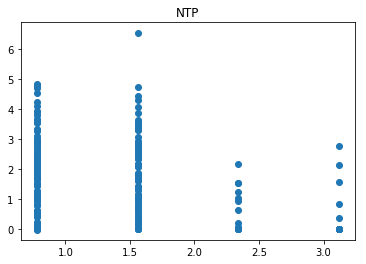

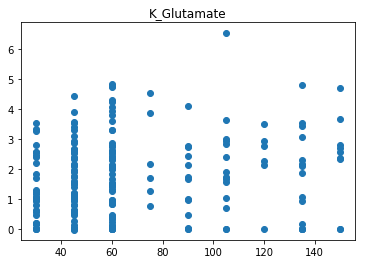

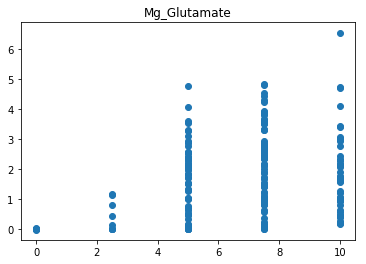

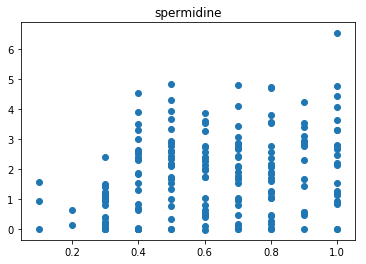

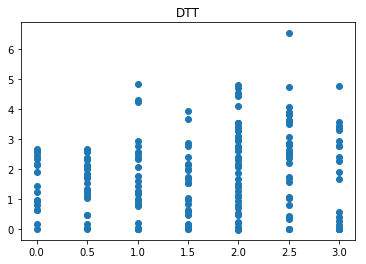

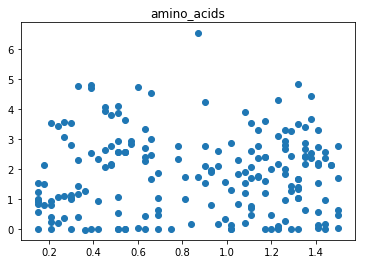

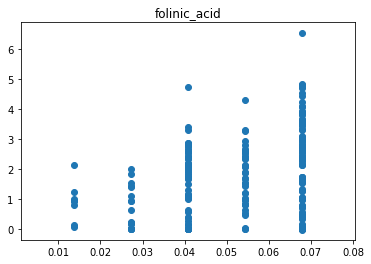

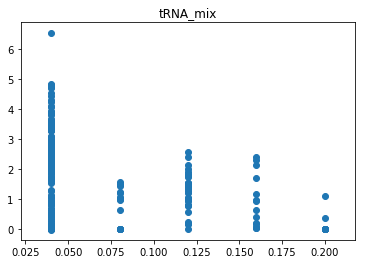

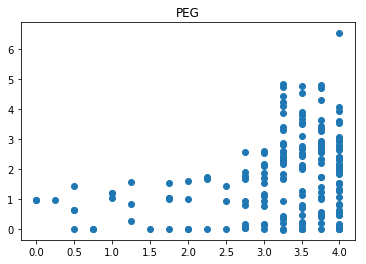

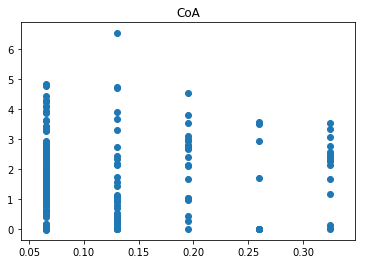

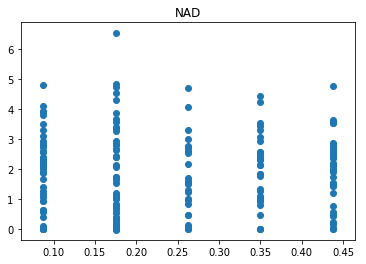

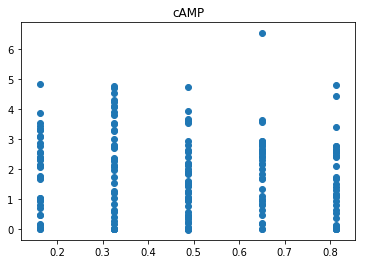

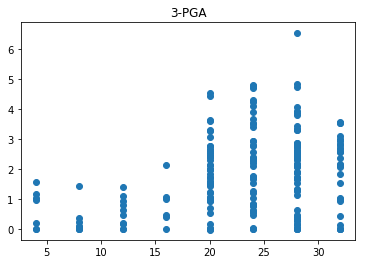

In [12]:
import matplotlib.pyplot as plt
import seaborn
for i in aggregated_data_20:
    plt.title(i)
    plt.scatter(aggregated_data_20[i].values, aggregated_label_20.values)
    plt.show()

In [22]:
# our ensemble of regressors

# it is an enhanced random forest algorithm

# best
regressors_list = [XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = n,
    learning_rate = 0.03,
    max_depth = 6,
    min_child_weight = 4,
    subsample = 0.9,
    gamma = 0.4,
    colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50)]

In [23]:
def bayesian_optimization(regressors_list,
                          data,  label,
                          concentrations_limits,
                          desired_cols, fixed_col_value, final_order,
                          exploitation=1, exploration=1, test_size=100, pool_size=100000, verbose=0):
    
    
    # first fit
    for regressor in regressors_list:
        regressor.fit(data.values, label.values)
        
    # make i th dataset
    df_1 = random_combination_generator(concentrations_limits, number_of_combination=pool_size, reaction_vol_nl=20000,
                                 check_max=True, max_nl=13200, drop_size_nl=100, make_csv=False, return_df=True)
 
    df_1 = df_1[desired_cols]
    
    df_temp = df_1.copy(deep=True)
    
    #upper Confidence Bound
    for index, regressor in enumerate(regressors_list):
        df_1['pred_yield_{}'.format(index)] = regressor.predict(df_temp.values)
        
    df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
    df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
    df_1['UCB'] = exploitation * df_1['mean_vote']+ exploration * df_1['regressors_std'] 
    df_1 = df_1.sort_values(['UCB'], ascending=False)
    
    chosen_combinations = df_1.iloc[0:test_size,0:len(desired_cols)].values
    chosen_combinations = pd.DataFrame(chosen_combinations, columns=desired_cols)
    
    for key, value in fixed_col_value.items():
        chosen_combinations[key] = value[0]

    chosen_combinations = chosen_combinations[final_order]
    
    return chosen_combinations

In [24]:
import time

In [25]:
desired_cols  = ['NTP', 'K_Glutamate', 'Mg_Glutamate', 'spermidine', 'DTT','amino_acids',
                     'folinic_acid', 'tRNA_mix', 'PEG', 'CoA', 'NAD', 'cAMP','3-PGA']

fixed_col_value = {'HEPES':[50.0], 'DNA':[20.0]}

final_order = ['NTP', 'HEPES', 'K_Glutamate', 'Mg_Glutamate', 'spermidine', 'DTT','amino_acids',
                      'folinic_acid', 'tRNA_mix', 'PEG', 'CoA', 'NAD', 'cAMP','3-PGA', 'DNA']

pool = 100000

t0 = time.time()

# exploration day 2, 3 = 1.41
# day 4, 5, 6, 7 = 1
# day 8, 9, 10 = 0.5
Concentrations_n_20 = bayesian_optimization(regressors_list, aggregated_data_20, aggregated_label_20, concentrations_limits,
                                         desired_cols=desired_cols, fixed_col_value=fixed_col_value, final_order=final_order,
                                         exploitation=1, exploration=0.5, test_size=20, pool_size=pool, verbose=0)

print(time.time()-t0)

Concentrations_n_20

15.81552505493164


,NTP,HEPES,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA,DNA
0,1.56,50.0,90.0,7.5,1.0,2.0,0.78,0.068,0.04,3.75,0.325,0.0875,0.8125,28.0,20.0
1,1.56,50.0,105.0,7.5,1.0,2.5,0.54,0.068,0.04,3.75,0.065,0.4375,0.6500,20.0,20.0
2,1.56,50.0,120.0,7.5,0.9,3.0,0.57,0.068,0.04,4.00,0.260,0.0875,0.6500,24.0,20.0
3,1.56,50.0,105.0,7.5,0.9,2.5,0.57,0.068,0.04,3.25,0.065,0.1750,0.6500,32.0,20.0
4,0.78,50.0,75.0,5.0,1.0,2.0,0.36,0.068,0.04,3.50,0.065,0.0875,0.3250,24.0,20.0
5,1.56,50.0,150.0,7.5,0.7,2.0,0.63,0.068,0.04,3.75,0.195,0.2625,0.3250,32.0,20.0
6,0.78,50.0,150.0,7.5,0.5,2.5,0.51,0.068,0.04,3.75,0.325,0.0875,0.6500,28.0,20.0
7,1.56,50.0,90.0,10.0,1.0,2.0,0.48,0.068,0.04,3.50,0.325,0.4375,0.1625,16.0,20.0
8,1.56,50.0,135.0,10.0,0.7,2.5,0.27,0.068,0.04,4.00,0.325,0.3500,0.1625,20.0,20.0
9,0.78,50.0,60.0,7.5,0.4,2.5,0.45,0.068,0.04,4.00,0.065,0.1750,0.4875,28.0,20.0


In [26]:
df_jove = pd.DataFrame(jove_protocol)
df_ours = pd.DataFrame(our_ref)
df_control = pd.DataFrame(control_neg)

Concentrations_n = pd.concat([Concentrations_n_20, df_ours, df_jove, df_ours, df_control]).reset_index(drop=True)
Concentrations_n.to_csv('../Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [27]:
# check to dont make repeated combination but it is not likly

df1 = pd.read_csv('../Day_1/Concentrations_1.csv')
df2 = pd.read_csv('../Day_2/Concentrations_2.csv')
df3 = pd.read_csv('../Day_3/Concentrations_3.csv')
df4 = pd.read_csv('../Day_4/Concentrations_4.csv')
df5 = pd.read_csv('../Day_5/Concentrations_5.csv')
df6 = pd.read_csv('../Day_6/Concentrations_6.csv')
df7 = pd.read_csv('../Day_7/Concentrations_7.csv')
df8 = pd.read_csv('../Day_8/Concentrations_8.csv')
df9 = pd.read_csv('../Day_9/Concentrations_9.csv')
df10 = pd.read_csv('../Day_10/Concentrations_10.csv')

df_main = pd.concat([df1.iloc[:20,:], df2.iloc[:20,:], df3.iloc[:20,:], df4.iloc[:20,:], df5.iloc[:20,:],
                     df6.iloc[:20,:], df7.iloc[:20,:], df8.iloc[:20,:], df9.iloc[:20,:]])

comparison_df = df_main.merge(df10.iloc[:20,:],
                          indicator=True,
                          how='outer')

comparison_df._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

In [28]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits,reaction_mixture_vol_nl=20000, lysate_ratio=0.33,
                                    add_lysate=True, make_csv=False)

Volumes_n.to_csv('../Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

In [29]:
# put_volumes_to_384_wells

# Maked triplicate
all_dataframe_n_1, named_n_1 = put_volumes_to_384_wells(Volumes_n, starting_well='A1', vertical=False)

named_n = named_n_1
named_n.to_csv('../Day_{}/Named_Volumes_{}.csv'.format(day+1, day+1), index=False)
named_n

,NTP,HEPES,K_Glutamate,Mg_Glutamate,spermidine,DTT,amino_acids,folinic_acid,tRNA_mix,PEG,CoA,NAD,cAMP,3-PGA,DNA,lysate,water,well_name
0,200.0,500.0,600.0,300.0,1000.0,400.0,2600.0,500.0,100.0,1500.0,500.0,100.0,500.0,700.0,400.0,6600.0,3500.0,A1
1,200.0,500.0,700.0,300.0,1000.0,500.0,1800.0,500.0,100.0,1500.0,100.0,500.0,400.0,500.0,400.0,6600.0,4400.0,A2
2,200.0,500.0,800.0,300.0,900.0,600.0,1900.0,500.0,100.0,1600.0,400.0,100.0,400.0,600.0,400.0,6600.0,4100.0,A3
3,200.0,500.0,700.0,300.0,900.0,500.0,1900.0,500.0,100.0,1300.0,100.0,200.0,400.0,800.0,400.0,6600.0,4600.0,A4
4,100.0,500.0,500.0,200.0,1000.0,400.0,1200.0,500.0,100.0,1400.0,100.0,100.0,200.0,600.0,400.0,6600.0,6100.0,A5
5,200.0,500.0,1000.0,300.0,700.0,400.0,2100.0,500.0,100.0,1500.0,300.0,300.0,200.0,800.0,400.0,6600.0,4100.0,A6
6,100.0,500.0,1000.0,300.0,500.0,500.0,1700.0,500.0,100.0,1500.0,500.0,100.0,400.0,700.0,400.0,6600.0,4600.0,A7
7,200.0,500.0,600.0,400.0,1000.0,400.0,1600.0,500.0,100.0,1400.0,500.0,500.0,100.0,400.0,400.0,6600.0,4800.0,A8
8,200.0,500.0,900.0,400.0,700.0,500.0,900.0,500.0,100.0,1600.0,500.0,400.0,100.0,500.0,400.0,6600.0,5200.0,A9
9,100.0,500.0,400.0,300.0,400.0,500.0,1500.0,500.0,100.0,1600.0,100.0,200.0,300.0,700.0,400.0,6600.0,5800.0,A10


In [ ]:
all_dataframe_n_1